# 0. Importing libraries

In [1]:
#pip install wordcloud

In [2]:
#pip install sentence_transformers

In [3]:
import numpy as np
import pandas as pd

import os
import time
import string

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

from wordcloud import WordCloud, STOPWORDS

# 1. Loading data

In [4]:
news_db_raw = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [5]:
news_db_raw.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
news_db_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


#  2. Data exploring

Feching only articles since 2018.01.01. This is my arbitrary choice and this doens't change the core of the project

In [7]:
news_db = news_db_raw.copy()

In [8]:
news_db = news_db[news_db['date']>= pd.Timestamp(2018,1,1)]

<b> 2.1 Removing duplicates </b>

In [9]:
news_db = news_db.drop_duplicates('headline', keep = 'first')
print("Total number of articles after removing duplicates:", news_db.shape[0])

Total number of articles after removing duplicates: 17199


In [10]:
print("Amount of all articles : ", news_db.shape[0])
print("Amount of authors :      ", len(news_db['authors'].unique()))
print("Amount of categories :   ", len(news_db['category'].unique()))

Amount of all articles :  17199
Amount of authors :       2280
Amount of categories :    36


<b> 2.2 Looking for NaN values</b>

In [11]:
news_db.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

 <b> 2.3. Exploring category column </b>

In [12]:
news_db['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING'], dtype=object)

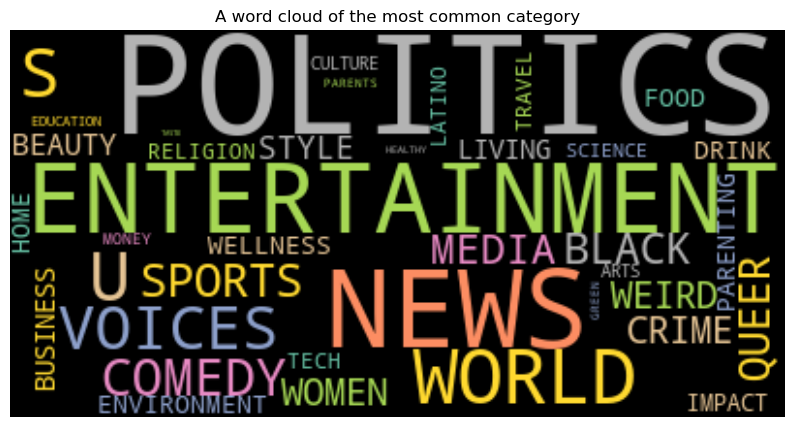

In [13]:
wordcloud = WordCloud(background_color='black', 
                      contour_color='black', 
                      random_state=3, 
                      colormap='Set2',  
                      collocations=False).generate(" ".join(news_db['category']))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('A word cloud of the most common category')
plt.axis("off")
plt.show()

Word cloud, also known as a tag cloud, is a visual representation of text data in which words are displayed in varying sizes, with the size of each word indicating its frequency or importance in the given text. 

In [14]:
news_category_df = pd.DataFrame(news_db['category'].value_counts()).reset_index()
news_category_df.rename(columns={'index': 'category',
                                 'count': 'amount'}, inplace=True)

Another representation of category distribution is a bar chart. Values on the top of each bar is the amount of articles in category. The plot shows 10 most commont category. As mentioned before data scope is since 2018.01.01

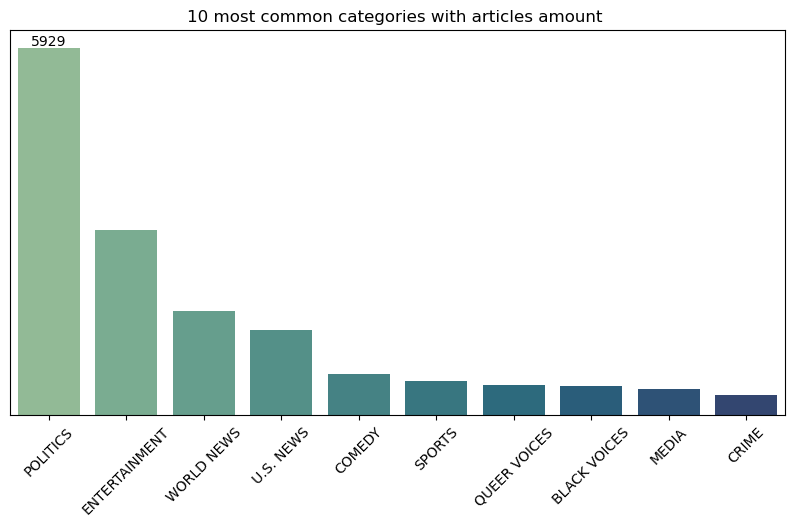

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
style = sns.color_palette("crest", n_colors=10)
ax = sns.barplot(x = news_category_df.category[:10], y = news_category_df.amount[:10], hue=news_category_df.category[:10], palette=style)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=45)
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('10 most common categories with articles amount ')
plt.show()

In [16]:
news_db_per_month_df = pd.DataFrame(news_db.resample('m', on = 'date')['headline'].count()).reset_index()
dates_label = news_db_per_month_df['date'].dt.strftime("%b'%y").values

 <b> 2.4. Amount of articles per month </b>

C:\Users\arkur\AppData\Local\Temp\ipykernel_28208\1162983685.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates_label, rotation='vertical')


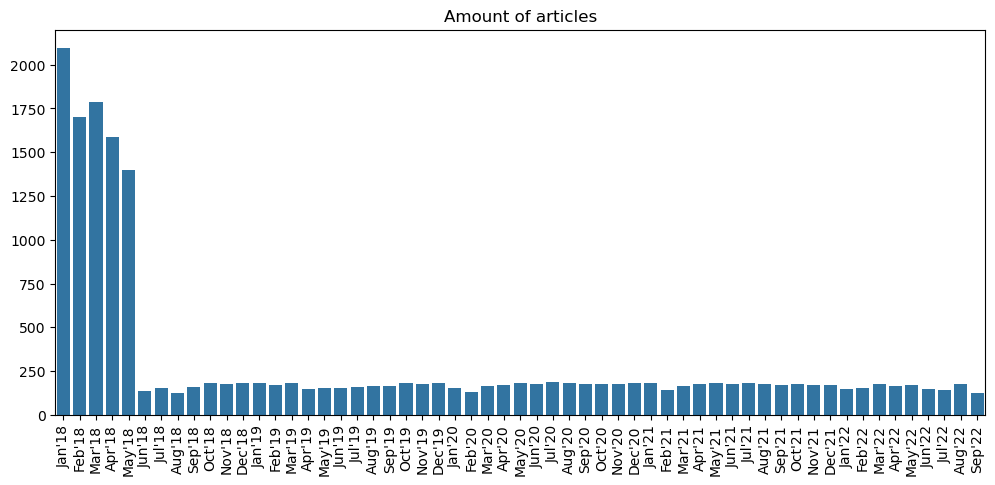

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x = news_db_per_month_df.date, y = news_db_per_month_df.headline)
ax.set_xticklabels(dates_label, rotation='vertical')
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('Amount of articles')
plt.show()

In the above bar chart we can see a huge disproportion in number of articles between january - may 2018 peroid and the rest. I will try to oberve how this influence on the finnal results. 

Below I present another word cloud. This time it shows the representatin of words in headlines

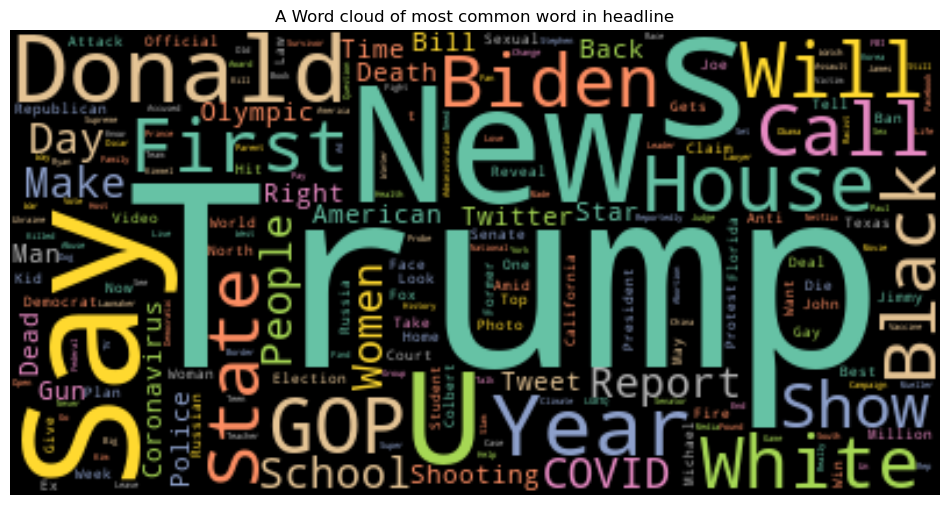

In [18]:
wordcloud = WordCloud(background_color='black', 
                      contour_color='black', 
                      random_state=42, 
                      colormap='Set2',  
                      collocations=False).generate(" ".join(news_db.headline))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('A Word cloud of most common word in headline')
plt.show()

 <b> 2.5 A kernel density estimator </b> 

In [19]:
np.array(news_db['headline'].str.len())

array([76, 89, 69, ..., 58, 58, 78], dtype=int64)

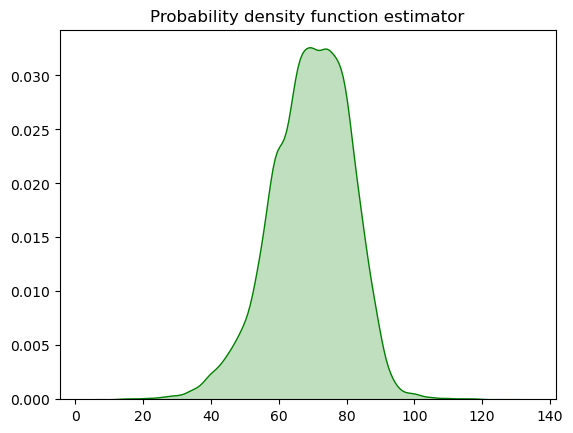

In [20]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data = news_db['headline'].str.len(), color='green', fill=True)
plt.xticks()
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('Probability density function estimator')


plt.show()

A kernel density estimator (KDE) is a non-parametric statistical method used to estimate the probability density function (PDF) of a continuous random variable. Here, in our data, most of the headline lenght are around 70 characters.

# 3. Text preprocessing

<b> 3.1. Removing stopwords, lemantization</b>

In [21]:
stop_words = stopwords.words('english')
all_stops = set(stopwords.words('english')) | set(string.punctuation)
lemmantizer = WordNetLemmatizer()

The goal of function below is to prepare data for similiarity counting process. The idea is to combine two columns: headline and article descroption. Thanks to this algorithm will have more information about specific article. 

In [22]:
headline_descr_combined = []

In [23]:
def text_preprocessing(df:pd.DataFrame):
    stop_words = stopwords.words('english')
    all_stops = set(stopwords.words('english')) | set(string.punctuation)
    lemmantizer = WordNetLemmatizer()

    temp_df = pd.DataFrame(columns=['combined_desc', 'category'])
    
    for index, row in df.iterrows():
        
        combined_desc = row['headline'].lower() + " "+ row['short_description'].lower()
        headline_descr_combined.append(combined_desc)
        tokenized_combined_desc = word_tokenize(combined_desc)
        lemantized_combined_desc = [lemmantizer.lemmatize(word) for word in tokenized_combined_desc]
        stop_words_removed = [word for word in tokenized_combined_desc if word not in all_stops]
        
        temp_df.loc[index] = {
            'combined_desc' : " ".join(stop_words_removed),
            'category' : row['category']
        }
    
    return temp_df

In [24]:
pd.set_option('display.max_colwidth', None)

In [25]:
df_pr = text_preprocessing(news_db)

In [26]:
df_pr.head(3)

,combined_desc,category
0,4 million americans roll sleeves omicron-targeted covid boosters health experts said early predict whether demand would match 171 million doses new boosters u.s. ordered fall,U.S. NEWS
1,american airlines flyer charged banned life punching flight attendant video subdued passengers crew fled back aircraft confrontation according u.s. attorney 's office los angeles,U.S. NEWS
2,23 funniest tweets cats dogs week sept. 17-23 `` dog n't understand could eaten '',COMEDY


# 4. Similiarity

 <b> 4.1. Tfidf Vectorizer </b>

TF-IDF vectorization is a text preprocessing technique used to convert a collection of documents (corpus) into numerical vectors. It is designed to represent the importance of individual terms (words) within each document relative to the entire corpus

In [27]:
# example model input. Combined headline and short description. WITH preprocessing
df_pr['combined_desc'].iloc[12]

'fiona threatens become category 4 storm headed bermuda hurricane fiona lashed turks caicos islands forecast squeeze past bermuda later week'

In [28]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_headline = tfidf_vectorizer.fit_transform(df_pr['combined_desc'])

In [29]:
def tfidf_func(row_index, num_similar_items):
    num_similar_items +=1
    
    pairwise_dist = pairwise_distances(tfidf_headline,tfidf_headline[row_index],metric='euclidean')
    mask = np.argsort(pairwise_dist.ravel())[1:num_similar_items]
    
    df = pd.DataFrame({'publish_date': news_db_raw['date'].iloc[mask].values,
               'headline':news_db_raw['headline'].iloc[mask].values,
                'short_description': news_db_raw['short_description'].iloc[mask].values,
                'category': news_db_raw['category'].iloc[mask].values,
                'Similarity with chosen article': pairwise_dist[mask].ravel()})
    
    print("*"*39, 'The chosen article',"*"*39)
    print("headline: ",news_db["headline"][row_index])
    print("description: ",news_db['short_description'][row_index])
    print("category: ",news_db["category"][row_index])
    print("date: ",news_db["date"][row_index].date())
    print("*"*35, 'A list of similar articles',"*"*35)
    
    return df.iloc[0:,]

In [30]:
tfidf_func(202, 5)

*************************************** The chosen article ***************************************
headline:  Trump Org. CFO To Plead Guilty, Testify Against Company
description:  Allen Weisselberg is charged with taking more than $1.7 million in off-the-books compensation from the Trump Organization over several years.
category:  CRIME
date:  2022-08-18
*********************************** A list of similar articles ***********************************


,publish_date,headline,short_description,category,Similarity with chosen article
0,2022-02-23,"Allen Weisselberg, Trump Organization Seek To Toss Tax Fraud Case",Lawyers for the Trump Organization's CFO are arguing that New York prosecutors targeted Weisselberg as punishment because he wouldn’t flip on the former president.,POLITICS,1.114150
1,2021-05-31,"Trump CFO 'Perjured Himself,' Felt 'Enabled' With Boss In White House: Ex-Daughter-In-Law","And Trump Organization Chief Financial Officer Allen Weisselberg will ""flip"" on Trump to save his sons, spilled Jennifer Weisselberg.",POLITICS,1.151078
2,2021-05-23,Ivanka Trump In A Fog In Deposition About Role Of Investigated Top Trump Executive,"After working for years in the Trump Organization, she apparently couldn't recall Allen Weisselberg has been the company's chief financial officer for decades.",POLITICS,1.198345
3,2019-03-03,John Bolton Dubs Trump-Kim Summit 'A Success' Despite No Denuclearization Deal,Trump's national security adviser also refused to weigh in on Otto Warmbier's killing.,POLITICS,1.227005
4,2018-02-20,Chrissy Teigen Proves She Knows Almost Nothing About Her Husband’s Career,"Ellen DeGeneres quizzed her about John Legend, and it... could have gone better.",ENTERTAINMENT,1.278834


 <b> 4.2. SentenceTransformer </b>

Sentence transformers uses  models which where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models.
There are many different pre-trained models which offers different quality,  speed.

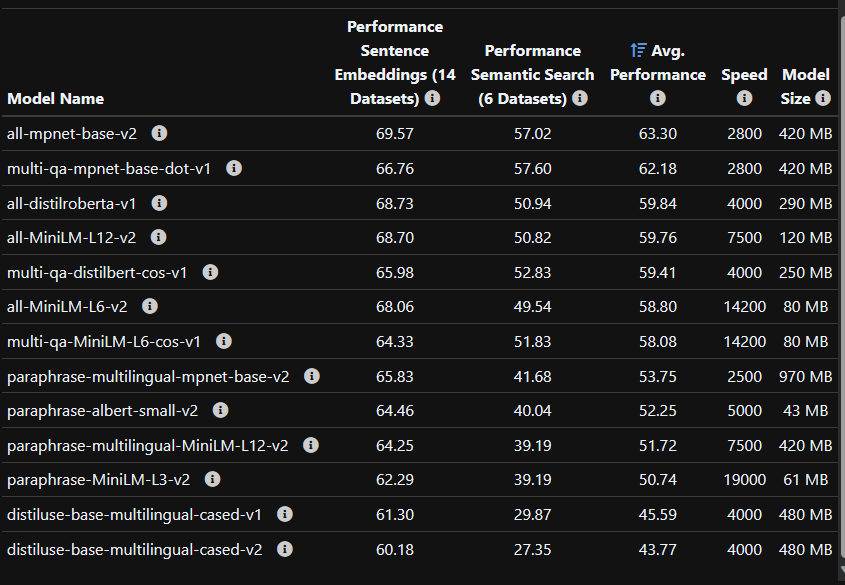


source: https://www.sbert.net/

In [31]:
# example model input. Combined headline and short description. No preprocessing
headline_descr_combined[12]

'fiona threatens to become category 4 storm headed to bermuda hurricane fiona lashed the turks and caicos islands and was forecast to squeeze past bermuda later this week.'

In [32]:
models_list = ['all-MiniLM-L6-v2', 'all-mpnet-base-v2', 'paraphrase-albert-small-v2']
model = SentenceTransformer(models_list[0])

In [33]:
headlines_embedding = model.encode(headline_descr_combined)

In [34]:
def sentence_trans_func(row_index, num_similar_items, all_embedding=headlines_embedding):
    num_similar_items +=1
    chosen_sentence = headline_descr_combined[row_index]
    sentence_embedding = model.encode(chosen_sentence)
    
    pairwise_dist = cosine_similarity([sentence_embedding], all_embedding).ravel()
    mask = np.argsort(-pairwise_dist)
    mask = mask[1: num_similar_items]
    
    df = pd.DataFrame({'publish_date': news_db['date'][mask].values,
               'headline':news_db['headline'].iloc[mask].values,
                'short_description': news_db['short_description'].iloc[mask].values,
                'category': news_db['category'].iloc[mask].values,
                'Similarity with chosen article': pairwise_dist.ravel()[mask]})
    
    print("*"*40, 'The chosen article',"*"*40)
    print("headline: ",news_db["headline"].iloc[row_index])
    print("description: ",news_db['short_description'].iloc[row_index])
    print("category: ",news_db["category"].iloc[row_index])
    print("date: ",news_db["date"].iloc[row_index].date())
    print("*"*35, 'A list of similar articles',"*"*35)
        
    return df.iloc[0:,]

In [35]:
sentence_trans_func(111,5)

**************************************** The chosen article ****************************************
headline:  Emergency Declared As Flash Flooding Hits Northwest Georgia
description:  Thunderstorms and heavy rain pounded parts of northwest Georgia on Sunday, sparking flash flooding and dangerously high waters in some areas.
category:  U.S. NEWS
date:  2022-09-04
*********************************** A list of similar articles ***********************************


,publish_date,headline,short_description,category,Similarity with chosen article
0,2021-06-19,Tropical Storm Claudette Raises Life-Threatening Flash Flooding,Heavy rain led to high water late Saturday into early Sunday in the Birmingham and Tuscaloosa metropolitan areas.,U.S. NEWS,0.618744
1,2022-08-07,Eastern Kentucky Braces For More Storms While Recovering From Extreme Flooding,The National Weather Service has extended a flood watch for areas of eastern Kentucky and said there’s a threat of thunderstorms in the region for much of the coming week.,U.S. NEWS,0.559635
2,2021-07-21,Dramatic Videos Show Deadly Flooding In China,People were trapped in waist-high water on the subway and cars floated through the streets as severe floods tore through China’s Henan province.,ENVIRONMENT,0.500857
3,2021-03-28,"4 Dead, More Than 100 Rescued After Heavy Rainfall Floods Tennessee",The deadly floodwaters follow Nashville's second-highest two-day rainfall total. Authorities have urged residents to stay home and not drive through the water.,U.S. NEWS,0.471365
4,2018-09-06,Florida Child Killed After Tropical Storm Gordon Strikes Land,"The threat is not over for residents in eight states, where heavy rains are expected to cause flash flooding.",U.S. NEWS,0.468507


# 5. Comparison of two approaches

In [36]:
choosen_article = 22
number_of_similar_articles = 10

In [37]:
%%capture
tfidf_results = tfidf_func(choosen_article, number_of_similar_articles)
tfidf_results.drop('Similarity with chosen article', axis = 1)
sentence_transformer_results = sentence_trans_func(choosen_article, number_of_similar_articles)
sentence_transformer_results.drop('Similarity with chosen article', axis = 1)

In [38]:
compare_df = pd.DataFrame({'publish_date_tfidf': tfidf_results['publish_date'],
               'headline_tfidf':tfidf_results['headline'],
                'category_tfidf': tfidf_results['category'],
                'publish_date_st': sentence_transformer_results['publish_date'],
               'headline_st':sentence_transformer_results['headline'],
                'category_st': sentence_transformer_results['category']})

In [39]:
print("*"*40, 'The chosen article',"*"*40)
print("headline: ",news_db["headline"].iloc[choosen_article])
print("category: ",news_db["category"].iloc[choosen_article])
print("date: ",news_db["date"].iloc[choosen_article].date())
print("*"*35, 'A list of similar articles',"*"*35)

**************************************** The chosen article ****************************************
headline:  Hurricane Fiona Bears Down On Dominican Republic After Pounding Puerto Rico
category:  WORLD NEWS
date:  2022-09-19
*********************************** A list of similar articles ***********************************


In [40]:
compare_df

,publish_date_tfidf,headline_tfidf,category_tfidf,publish_date_st,headline_st,category_st
0,2022-09-17,Puerto Rico Braces For Landslides And Severe Flooding As Tropical Storm Fiona Approaches,ENVIRONMENT,2022-09-17,Puerto Rico Braces For Landslides And Severe Flooding As Tropical Storm Fiona Approaches,ENVIRONMENT
1,2020-01-07,Iranian Foreign Minister Says Iran Will Respond 'Proportionately' To Soleimani Assassination,WORLD NEWS,2022-09-21,Fiona Threatens To Become Category 4 Storm Headed To Bermuda,WORLD NEWS
2,2022-09-20,Fiona Barrels Toward Turks And Caicos Islands As Category 3 Hurricane,WORLD NEWS,2022-09-20,Fiona Barrels Toward Turks And Caicos Islands As Category 3 Hurricane,WORLD NEWS
3,2018-08-11,Heartbreaking Seattle Plane Crash Drama Unfolded Live On Control Tower Broadcast,U.S. NEWS,2022-09-22,Puerto Ricans Desperate For Water After Hurricane Fiona’s Rampage,WORLD NEWS
4,2018-01-18,USA Gymnastics Cuts Ties With Training Center Where Athletes Say Nassar Abused Them,SPORTS,2018-08-11,"Puerto Rico Concedes Hurricane Maria Deaths Were More Than 1,400",U.S. NEWS
5,2018-01-31,Lawmakers Wear Black To Donald Trump’s State Of The Union Address,POLITICS,2018-09-13,"20,000 Pallets Of Water Bottles Were Left In Puerto Rico, And No One Seems To Know Why",U.S. NEWS
6,2019-04-09,"3 Americans Killed, Contractor Injured In Roadside Blast In Afghanistan",U.S. NEWS,2020-01-07,6.4 Quake Strikes Puerto Rico Amid Heavy Seismic Activity,U.S. NEWS
7,2019-07-22,Trump Administration Pauses Enforcement Of Abortion Restriction,U.S. NEWS,2018-09-15,Trump Fumes Over Puerto Rico Toll As Death Count Rises For Hurricane Florence,POLITICS
8,2018-02-04,Florida Police Thwart Man's Attempt To Kidnap Singer Lana Del Rey,ENTERTAINMENT,2019-09-03,"Record-Setting Hurricane Dorian Batters Northern Bahamas, Leaves Trail Of Destruction",WORLD NEWS
9,2018-06-05,Watch Rare Footage Of San Francisco's 1906 Earthquake Devastation,U.S. NEWS,2020-01-17,Trump Signs Puerto Rico Emergency Declaration Following Earthquake,POLITICS


<b> comment on the results </b> 

In this excample ( article nr 22) both models select the same article as the most similar to the queried one. If we move forward we can see that in sentence transformer model next 3 articles are quite close to the date of article nr 22. In TFIDF 2nd proposed article comes from 2020-01-07. Article placed on 3rd position is the same in both models. Generally more headlines selected by sentence transformer model contain 'Puerto Rico'. Of course my approach take into the account not only headline but also descripton od the article. 
TFIDF model selected 2 articles categorized as SPORTS and ENTERTAINMENT which we can consider as drawback. 


if we look again at distribution of the number of articles we can see disproporiton between the first 5 months of 2018 and the rest. In the results generated by the TFIDF model 3 of 10 articles comes from the beggining of 2018. Sentence Tranformer model doesn't contain any articles from this peroid. 
 

#  6. Weighted similarity based on headline, category and date


Here I add possibility to decide if we want to take into a account the category of the article and we can specify the weights of headline (w1), category (w2) and date (w3). In this case we take results from tfidf model.

In [41]:
category_ohe = OneHotEncoder()

In [42]:
category_onehot_encoded =category_ohe.fit_transform(np.array(news_db["category"]).reshape(-1,1))

In [43]:
date_onehot_encoded = category_ohe.fit_transform(np.array(news_db["date"]).reshape(-1,1))

In [44]:
def weighted_results(row_index, num_similar_items, w1, w2, w3):
    num_similar_items +=1
    
    pairwise_dist = pairwise_distances(tfidf_headline,tfidf_headline[row_index])
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) +1
    date_dist = pairwise_distances(date_onehot_encoded, date_onehot_encoded[row_index])
    
    weighted_result = (w1*pairwise_dist + w2*category_dist + w3 * date_dist)/float(w1 + w2 + w3)
    mask = np.argsort(weighted_result.flatten())[0:num_similar_items].tolist()
    
    df = pd.DataFrame(
    {'published data': news_db["date"].iloc[mask].values,
    'headline': news_db["headline"].iloc[mask].values,
    'Category': news_db['category'].iloc[mask].values
    }
    )
    print("*"*40, 'The chosen article',"*"*40)
    print("headline: ",news_db["headline"][row_index])
    print("descroption: ",news_db["short_description"][row_index])
    print("category: ",news_db["category"][row_index])
    print("date: ",news_db["date"][row_index].date())
    print("*"*35, 'A list of similar articles',"*"*35)
    
    return df.iloc[0:,]

In [45]:
weighted_results(22,10 , w1=0.6, w2=0.2, w3=0.2)

**************************************** The chosen article ****************************************
headline:  Hurricane Fiona Bears Down On Dominican Republic After Pounding Puerto Rico
descroption:  The storm knocked out the power grid and unleashed floods and landslides in Puerto Rico, where the governor said the damage was “catastrophic.”
category:  WORLD NEWS
date:  2022-09-19
*********************************** A list of similar articles ***********************************


,published data,headline,Category
0,2022-09-19,Hurricane Fiona Bears Down On Dominican Republic After Pounding Puerto Rico,WORLD NEWS
1,2022-09-20,Fiona Barrels Toward Turks And Caicos Islands As Category 3 Hurricane,WORLD NEWS
2,2022-09-22,Puerto Ricans Desperate For Water After Hurricane Fiona’s Rampage,WORLD NEWS
3,2019-07-28,Woman Expected To Replace Puerto Rico Governor Rejects Bid Amid Political Crisis,WORLD NEWS
4,2022-09-21,Fiona Threatens To Become Category 4 Storm Headed To Bermuda,WORLD NEWS
5,2022-03-17,"Strong Japan Earthquake Kills 4, Injures 107",WORLD NEWS
6,2020-01-06,"After Indonesia's Deadly Floods, Few Hear Climate 'Wake Up Call'",WORLD NEWS
7,2019-07-14,"Floods, Landslides Leave Dozens Dead Across Nepal And India",WORLD NEWS
8,2019-09-12,"2,500 People Are Reported Missing In The Bahamas After Hurricane Dorian",WORLD NEWS
9,2018-09-06,"Japanese Earthquake Triggers Deadly Landslides, Knocks Out Power To Millions",WORLD NEWS
